In [54]:
import os
import sys
sys.path.append(os.pardir)
import numpy as np
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

In [ ]:
# 畳み込みニュートラルネットワーク(CNN)
# 今まで
# 入力→アフィン→ReLU→…アフィン→ReLU→アフィン→Softmax→
# 隣接する層のすべてのニューロン間で結合がある→全結合
# すべての入力データを1次元のデータにする→一列のデータにする
# →色とかの情報は単一の価値になる→色の判断とかできない
# 今までは黒白の濃淡だけを保存していた
# CNN
# 入力→Convolution→ReLU→Pooling→…アフィン→ReLU→アフィン→Softmax→
# Convolution:畳み込み層、Pooling:プーリング層
# 畳み込み層での入出力データ:特徴マップ(入力:入力特徴マップ、出力:出力特徴マップ）
# 3次元(R、G、B)で処理が進む

In [ ]:
# 畳み込み層
# 畳み込み演算：入力データに対してフィルタ(カーネル)を適用→積和演算
# 入力データに対してフィルタを一定の間隔でスライドさせながら
# フィルタの要素と入力に対応する要素を乗算しその合計を配列に
# フィルターが今までの重みに相当、バイアスもある
# 
# (4,4)の入力→(3,3)のフィルタ→(2,2)でそれぞれにバイアスを加算して出力
# フィルタで小さくなったらダメじゃん→どんどん小さくなって層を重ねられん

# パディング
# 入力データの周囲に固定データ(0とか)を埋めること
# 幅も設定できる例:(4,4)に幅1のパディング→(6,6)
# (4,4)に幅1のパディング * (3,3)のフィルタ→(4,4)
# これで出力を入力と同じにする
# ずれってどうやって制御するの？

# ストライド
# フィルタの適用位置の間隔

# 出力の算出方法
# 入力データ(H,W)、フィルタ(FH,FW)、パディングP、スライドS、出力(OH,OW)
# Oh = 1 + (H + 2P - Fh) / S
# Wも同じ
# 小数の場合は対応が必要(エラーメッセor切り上げ捨て・四捨五入)

# フィルタは入力と同じ次元じゃないとだめだよ
# ３次元の時を考えると出力は2次元になってしまう
# (C,H,W) * (C,FH,FW)→(1,OH,OW)
# これはさっきと同じ
# ３次元のフィルタをFN個作る
# (C,H,W) * (FN,C,FH,FW)→(FN,OH,OW)
# バイアスを含めると
# (C,H,W) * (FN,C,FH,FW)→(FN,OH,OW) + (FN,1,1) →　(N,FN,OH,OW)

# バッチ処理
# N個のバッチを処理を行う
# (N,C,H,W) * (FN,C,FH,FW)→(N,FN,OH,OW) + (FN,1,1) →　(N,FN,OH,OW)
# これで一括送信してるから
# N回繰り返し×→N個まとめて処理〇

# プーリング層
# 縦横を小さくする
# V(縦)×S(横)でプーリング
# その範囲で一番大きい(Max)or平均(Average)を抽出
# ストライドは基本Sと同じ
# (4,4)を(2,2)でMaxプーリング→(2,2)の範囲で一番大きい値を選択→(2,2)
# 特徴
# 学習するパラメータが存在しない→加工するだけだからMaxかAveにするのと(V,S)を決めるくらい
# チャンネル数が変化しない→上記と同じ
# 微小な位置変化に対して強い→プーリング範囲で数値の位置がそれぞれ違っても関係ない→位置に依存していない

In [55]:
# 実装
# forwordとbackword
# 4次元配列(10個,チャンネル,縦,横)
x = np.random.rand(10,1,28,28)
x.shape #全体の大きさ
x[0].shape#1個目のデータ全体の大きさ
x[0][0].shape#１チャンネルの大きさ
x[0][0][0].shape
# 4次元の計算の実装って大変じゃね？
# for データ数
#  for チャンネル
#   for 縦
# 　 for 横
#  は重すぎ
# NumPyは繰り返しを基本さける
# im2colをつかうと簡単:「image to column」画像から行列へ
# フィルタの都合がいいように展開してくれる関数
# 入力データ(バッチ数含めた4次元データ)に対して2次元データ(行列)に変換
# フィルタを使う領域(3次元)を横方向1列に展開→適用する場所すべてで行う
# フィルタが重なるときもうまくやってくる→でも要素数が元のブロックよりも多くなる→PCのメモリを消費する
# PC上の理由はどうにかなる + 行列の計算は最適化されていていろいろなライブラリを使える

(28,)

In [56]:
# im2colメソッドの中身→そういうものとして使う：順伝播
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

# 逆伝播の時に使う
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [21]:
x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1,5,5,stride=1,pad=0)
print(col1.shape)

x2 = np.random.rand(10,4,7,7)
col2 = im2col(x2,5,5,stride=1,pad=0)
print(col2.shape)
# 75はチャンネル数*フィルタ縦*フィルタ横

(9, 75)
(90, 100)


In [57]:
# Convolutionの実装
class Convolution:
    def __init__(self,W,b,stride=1,pad=0):
        """Convolutionレイヤー

        Args:
            W (numpy.ndarray): フィルター（重み）、形状は(FN, C, FH, FW)。
            b (numpy.ndarray): バイアス、形状は(FN)。
            stride (int, optional): ストライド、デフォルトは1。
            pad (int, optional): パディング、デフォルトは0。
        """
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.dW = None      # 重みの微分値
        self.db = None      # バイアスの微分値

        self.x = None       # 逆伝播で必要になる、順伝播時の入力
        self.col_x = None   # 逆伝播で必要になる、順伝播時の入力のcol展開結果
        self.col_W = None   # 逆伝播で必要になる、順伝播時のフィルターのcol展開結果
    
    def forward(self,x):
        """順伝播

        Args:
            x (numpy.ndarray): 入力。形状は(N, C, H, W)。

        Returns:
            numpy.ndarray: 出力。形状は(N, FN, OH, OW)。
        """
        FN,C,FH,FW = self.W.shape  # FN:フィルター数、C:チャンネル数、FH:フィルターの高さ、FW:幅
        N,x_C,H,W = x.shape        # N:バッチサイズ、x_C:チャンネル数、H：入力データの高さ、W:幅
        # 自分で設定したエラーをはいて停止できる
        assert C == x_C, f'チャンネル数の不一致！[C]{C}, [x_C]{x_C}'

        # 出力のサイズ算出
        assert (H + 2 * self.pad - FH) % self.stride == 0, 'OHが割り切れない！'
        assert (W + 2 * self.pad - FW) % self.stride == 0, 'OWが割り切れない！'
        OH = int((H + 2 * self.pad - FH) / self.stride + 1)
        OW = int((W + 2 * self.pad - FW) / self.stride + 1)

        # 入力データを展開
        # (N, C, H, W) → (N * OH * OW, C * FH * FW)
        col_x = im2col(x, FH, FW, self.stride, self.pad)

        # フィルターを展開(.Tで転置)
        # (FN, C, FH, FW) → (FN, C * FH * FW)→(C * FH * FW, FN)
        col_W = self.W.reshape(FN, -1).T

        # 出力を算出（col_x, col_W, bに対する計算は、Affineレイヤーと全く同じ）
        # (N * OH * OW, C * FH * FW)・(C * FH * FW, FN) → (N * OH * OW, FN)
        out = np.dot(col_x, col_W) + self.b

        # 結果の整形
        # (N * OH * OW, FN) → (N, OH, OW, FN) → (N, FN, OH, OW)
        out = out.reshape(N, OH, OW, FN).transpose(0, 3, 1, 2)

        # 逆伝播のために保存
        self.x = x
        self.col_x = col_x
        self.col_W = col_W

        return out
    
    def backward(self, dout):
        """逆伝播

        Args:
            dout (numpy.ndarray): 右の層から伝わってくる微分値、形状は(N, FN, OH, OW)。

        Returns:
            numpy.ndarray: 微分値（勾配）、形状は(N, C, H, W)。
        """
        FN,C,FH,FW = self.W.shape  # 微分値の形状はWと同じ(FN, C, FH, FW)

        # 右の層からの微分値を展開
        # (N, FN, OH, OW) → (N, OH, OW, FN) → (N * OH * OW, FN)
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        # 微分値算出（col_x, col_W, bに対する計算は、Affineレイヤーと全く同じ）
        dcol_x = np.dot(dout, self.col_W.T)     # → (N * OH * OW, C * FH * FW)
        self.dW = np.dot(self.col_x.T, dout)    # → (C * FH * FW, FN)
        self.db = np.sum(dout, axis=0)          # → (FN)

        # フィルター（重み）の微分値の整形
        # (C * FH * FW, FN) → (FN, C * FH * FW) → (FN, C, FH, FW)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        # 結果（勾配）の整形
        # (N * OH * OW, C * FH * FW) → (N, C, H, W)
        dx = col2im(dcol_x, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [58]:
# Poolingの実装
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        """Poolingレイヤー

        Args:
            pool_h (int): プーリング領域の高さ
            pool_w (int): プーリング領域の幅
            stride (int, optional): ストライド、デフォルトは1。
            pad (int, optional): パディング、デフォルトは0。
        """
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None           # 逆伝播で必要になる、順伝播時の入力
        self.arg_max = None     # 逆伝播で必要になる、順伝播時に採用したcol_x各行の位置

    def forward(self, x):
        """順伝播

        Args:
            x (numpy.ndarray): 入力、形状は(N, C, H, W)。

        Returns:
            numpy.ndarray: 出力、形状は(N, C, OH, OW)。
        """
        N, C, H, W = x.shape  # N:データ数、C:チャンネル数、H:高さ、W:幅

        # 出力のサイズ算出
        assert (H - self.pool_h) % self.stride == 0, 'OHが割り切れない！'
        assert (W - self.pool_w) % self.stride == 0, 'OWが割り切れない！'
        OH = int((H - self.pool_h) / self.stride + 1)
        OW = int((W - self.pool_w) / self.stride + 1)

        # 入力データを展開、整形
        # (N, C, H, W) → (N * OH * OW, C * PH * PW)
        col_x = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # (N * OH * OW, C * PH * PW) → (N * OH * OW * C, PH * PW)
        col_x = col_x.reshape(-1, self.pool_h * self.pool_w)

        # 出力(最大値)を算出
        # (N * OH * OW * C, PH * PW) → (N * OH * OW * C)
        out = np.max(col_x, axis=1)

        # 出力の整形
        # (N * OH * OW * C) → (N, OH, OW, C) → (N, C, OH, OW)
        out = out.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)

        # 逆伝播のために保存
        self.x = x
        self.arg_max = np.argmax(col_x, axis=1)  # col_x各行の最大値の位置（インデックス）

        return out

    def backward(self, dout):
        """逆伝播

        Args:
            dout (numpy.ndarray): 右の層から伝わってくる微分値、形状は(N, C, OH, OW)。

        Returns:
            numpy.ndarray: 微分値（勾配）、形状は(N, C, H, W)。
        """
        # 右の層からの微分値を整形
        # (N, C, OH, OW) → (N, OH, OW, C)
        dout = dout.transpose(0, 2, 3, 1)

        # 結果の微分値用のcolを0で初期化
        # (N * OH * OW * C, PH * PW)
        pool_size = self.pool_h * self.pool_w
        dcol_x = np.zeros((dout.size, pool_size))

        # 順伝播時に最大値として採用された位置にだけ、doutの微分値（＝doutまんま）をセット
        # 順伝播時に採用されなかった値の位置は初期化時の0のまま
        # （ReLUでxが0より大きい場合およびxが0以下の場合の処理と同じ）
        assert dout.size == self.arg_max.size, '順伝搬時のcol_xの行数と合わない'
        dcol_x[np.arange(self.arg_max.size), self.arg_max.flatten()] = \
            dout.flatten()

        # 結果の微分値の整形1
        # (N * OH * OW * C, PH * PW) → (N, OH, OW, C, PH * PW)
        dcol_x = dcol_x.reshape(dout.shape + (pool_size,))  # 最後の','は1要素のタプルを示す

        # 結果の微分値の整形2
        # (N, OH, OW, C, PH * PW) → (N * OH * OW, C * PH * PW)
        dcol_x = dcol_x.reshape(
            dcol_x.shape[0] * dcol_x.shape[1] * dcol_x.shape[2], -1
        )

        # 結果の微分値の整形3
        # (N * OH * OW, C * PH * PW) → (N, C, H, W)
        dx = col2im(
            dcol_x, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad
        )

        return dx

In [39]:
# CNNの実装に必要なメソッド
# ReLU
class ReLU:
    def __init__(self):
        """ReLUレイヤー
        """
        self.mask = None

    def forward(self, x):
        """順伝播

        Args:
            x (numpy.ndarray): 入力

        Returns:
            numpy.ndarray: 出力
        """
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        """逆伝播

        Args:
            dout (numpy.ndarray): 右の層から伝わってくる微分値

        Returns:
            numpy.ndarray: 微分値
        """
        dout[self.mask] = 0
        dx = dout

        return dx

In [59]:
# Affine
import numpy as np


class Affine:

    def __init__(self, W, b):
        """Affineレイヤー

        Args:
            W (numpy.ndarray): 重み
            b (numpy.ndarray): バイアス
        """
        self.W = W                      # 重み
        self.b = b                      # バイアス
        self.x = None                   # 入力（2次元化後）
        self.dW = None                  # 重みの微分値
        self.db = None                  # バイアスの微分値
        self.original_x_shape = None    # 元の入力の形状（3次元以上の入力時用）

    def forward(self, x):
        """順伝播

        Args:
            x (numpy.ndarray): 入力

        Returns:
            numpy.ndarray: 出力
        """
        # 3次元以上（テンソル）の入力を2次元化
        self.original_x_shape = x.shape  # 形状を保存、逆伝播で戻す必要があるので
        x = x.reshape(x.shape[0], -1)
        self.x = x

        # 出力を算出
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        """逆伝播

        Args:
            dout (numpy.ndarray): 右の層から伝わってくる微分値

        Returns:
            numpy.ndarray: 微分値
        """
        # 微分値算出
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        # 元の形状に戻す
        dx = dx.reshape(*self.original_x_shape)
        return dx

In [60]:
# Softmax + 損失関数
class SoftmaxWithLoss:
    def __init__(self):
        """Softmax-with-Lossレイヤー
        """
        self.loss = None    # 損失
        self.y = None       # softmaxの出力
        self.t = None       # 教師データ（one-hot vector）

    def forward(self, x, t):
        """順伝播

        Args:
            x (numpy.ndarray): 入力
            t (numpy.ndarray): 教師データ

        Returns:
            float: 交差エントロピー誤差
        """
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        """逆伝播

        Args:
            dout (float, optional): 右の層から伝わってくる微分値。デフォルトは1。

        Returns:
            numpy.ndarray: 微分値
        """
        batch_size = self.t.shape[0]    # バッチの個数
        dx = (self.y - self.t) * (dout / batch_size)

        return dx

In [61]:
# ハイパーパラメータの更新
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
#           1e-7で0除算を避けている
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [62]:
# Softmaxと交差エントロピー誤差メソッド
def softmax(x):
    """ソフトマックス関数

    Args:
        x (numpy.ndarray): 入力

    Returns:
        numpy.ndarray: 出力
    """
    # バッチ処理の場合xは(バッチの数, 10)の2次元配列になる。
    # この場合、ブロードキャストを使ってうまく画像ごとに計算する必要がある。
    # ここでは1次元でも2次元でも共通化できるようnp.max()やnp.sum()はaxis=-1で算出し、
    # そのままブロードキャストできるようkeepdims=Trueで次元を維持する。
    c = np.max(x, axis=-1, keepdims=True)
    exp_a = np.exp(x - c)  # オーバーフロー対策
    sum_exp_a = np.sum(exp_a, axis=-1, keepdims=True)
    y = exp_a / sum_exp_a
    return y


def cross_entropy_error(y, t):
    """交差エントロピー誤差の算出

    Args:
        y (numpy.ndarray): ニューラルネットワークの出力
        t (numpy.ndarray): 正解のラベル

    Returns:
        float: 交差エントロピー誤差
    """

    # データ1つ場合は形状を整形（1データ1行にする）
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 誤差を算出してバッチ数で正規化
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [63]:
# CNNの実装
class SimpleConvNet:

    def __init__(
        self, input_dim=(1, 28, 28),
        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
        hidden_size=100, 
        output_size=10, 
        weight_init_std=0.01
    ):
        """シンプルな畳み込みニューラルネットワーク

        Args:
            input_dim (tuple, optional): 入力データの形状、デフォルトは(1, 28, 28)。
            conv_param (dict, optional): 畳み込み層のハイパーパラメーター、
                デフォルトは{'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}。
            hidden_size (int, optional): 隠れ層のニューロンの数、デフォルトは100。
            output_size (int, optional): 出力層のニューロンの数、デフォルトは10。
            weight_init_std (float, optional): 重みの初期値の調整パラメーター。デフォルトは0.01。
        """
        # 畳み込み層のハイパーパラメーター取り出し
        filter_num = conv_param['filter_num']       # フィルター数
        filter_size = conv_param['filter_size']     # フィルターのサイズ（高さ・幅同じ）
        filter_stride = conv_param['stride']        # ストライド
        filter_pad = conv_param['pad']              # パディング

        # プーリング層のハイパーパラメーターは固定
        pool_size = 2                               # サイズ（高さ・幅同じ）
        pool_stride = 2                             # ストライド
        pool_pad = 0                                # パディング

        # 入力データのサイズ算出
        input_ch = input_dim[0]                     # 入力データのチャンネル数
        assert input_dim[1] == input_dim[2], '入力データは高さと幅が同じ前提！'
        input_size = input_dim[1]                   # 入力データのサイズ

        # 畳み込み層の出力サイズ算出
        assert (input_size + 2 * filter_pad - filter_size) \
            % filter_stride == 0, '畳み込み層の出力サイズが割り切れない！'
        conv_output_size = int(
            (input_size + 2 * filter_pad - filter_size) / filter_stride + 1
        )

        # プーリング層の出力サイズ算出
        assert (conv_output_size - pool_size) % pool_stride == 0, \
            'プーリング層の出力サイズが割り切れない！'
        pool_output_size_one = int(
            (conv_output_size - pool_size) / pool_stride + 1  # 高さ・幅のサイズ
        )
        pool_output_size = filter_num * \
            pool_output_size_one * pool_output_size_one     # 全フィルターの合計サイズ

        # 重みの初期化
        self.params = {}
        # 畳み込み層
        self.params['W1'] = weight_init_std * \
            np.random.randn(filter_num, input_ch, filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        # Affine層1
        self.params['W2'] = weight_init_std * \
            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        # Affine層2
        self.params['W3'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤー生成
        self.layers = {}    # Python 3.7からは辞書の格納順が保持されるので、OrderedDictは不要
        # 畳み込み層
        self.layers['Conv1'] = Convolution(
            self.params['W1'], self.params['b1'], filter_stride, filter_pad
        )
        self.layers['Relu1'] = ReLU()
        self.layers['Pool1'] = Pooling(
            pool_size, pool_size, pool_stride, pool_pad
        )
        # Affine層1
        self.layers['Affine1'] = \
            Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = ReLU()
        # Affine層2
        self.layers['Affine2'] = \
            Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        """ニューラルネットワークによる推論

        Args:
            x (numpy.ndarray): ニューラルネットワークへの入力

        Returns:
            numpy.ndarray: ニューラルネットワークの出力
        """
        # レイヤーを順伝播
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数の値算出

        Args:
            x (numpy.ndarray): ニューラルネットワークへの入力
            t (numpy.ndarray): 正解のラベル

        Returns:
            float: 損失関数の値
        """
        # 推論
        y = self.predict(x)

        # Softmax-with-Lossレイヤーの順伝播で算出
        loss = self.lastLayer.forward(y, t)

        return loss

    def accuracy(self, x, t, batch_size=100):
        """認識精度算出
        batch_sizeは算出時のバッチサイズ。一度に大量データを算出しようとすると
        im2colでメモリを食い過ぎてスラッシングが起きてしまい動かなくなるため、
        その回避のためのもの。

        Args:
            x (numpy.ndarray): ニューラルネットワークへの入力
            t (numpy.ndarray): 正解のラベル（one-hot）
            batch_size (int), optional): 算出時のバッチサイズ、デフォルトは100。

        Returns:
            float: 認識精度
        """
        # 分割数算出
        batch_num = max(int(x.shape[0] / batch_size), 1)

        # 分割
        x_list = np.array_split(x, batch_num, 0)
        t_list = np.array_split(t, batch_num, 0)

        # 分割した単位で処理
        correct_num = 0  # 正答数の合計
        for (sub_x, sub_t) in zip(x_list, t_list):
            assert sub_x.shape[0] == sub_t.shape[0], '分割境界がずれた？'
            y = self.predict(sub_x)
            y = np.argmax(y, axis=1)
            t = np.argmax(sub_t, axis=1)
            correct_num += np.sum(y == t)

        # 認識精度の算出
        return correct_num / x.shape[0]

    def gradient(self, x, t):
        """重みパラメーターに対する勾配を誤差逆伝播法で算出

         Args:
            x (numpy.ndarray): ニューラルネットワークへの入力
            t (numpy.ndarray): 正解のラベル

        Returns:
            dictionary: 勾配を格納した辞書
        """
        # 順伝播
        self.loss(x, t)     # 損失値算出のために順伝播する

        # 逆伝播
        dout = self.lastLayer.backward()
        for layer in reversed(list(self.layers.values())):
            dout = layer.backward(dout)

        # 各レイヤーの微分値を取り出し
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

学習前 [訓練データの認識精度]0.1042 [テストデータの認識精度]0.1001
[エポック] 1 [更新数]  600 [損失関数の値]0.0237 [訓練データの認識精度]0.9774 [テストデータの認識精度]0.9776
[エポック] 2 [更新数] 1200 [損失関数の値]0.0107 [訓練データの認識精度]0.9835 [テストデータの認識精度]0.9828
[エポック] 3 [更新数] 1800 [損失関数の値]0.0178 [訓練データの認識精度]0.9867 [テストデータの認識精度]0.9834
[エポック] 4 [更新数] 2400 [損失関数の値]0.0090 [訓練データの認識精度]0.9873 [テストデータの認識精度]0.9841
[エポック] 5 [更新数] 3000 [損失関数の値]0.0162 [訓練データの認識精度]0.9898 [テストデータの認識精度]0.9849
[エポック] 6 [更新数] 3600 [損失関数の値]0.0098 [訓練データの認識精度]0.9909 [テストデータの認識精度]0.9851
[エポック] 7 [更新数] 4200 [損失関数の値]0.0034 [訓練データの認識精度]0.9919 [テストデータの認識精度]0.9864
[エポック] 8 [更新数] 4800 [損失関数の値]0.0029 [訓練データの認識精度]0.9924 [テストデータの認識精度]0.9861
[エポック] 9 [更新数] 5400 [損失関数の値]0.0137 [訓練データの認識精度]0.9937 [テストデータの認識精度]0.9849
[エポック]10 [更新数] 6000 [損失関数の値]0.0101 [訓練データの認識精度]0.9940 [テストデータの認識精度]0.9853


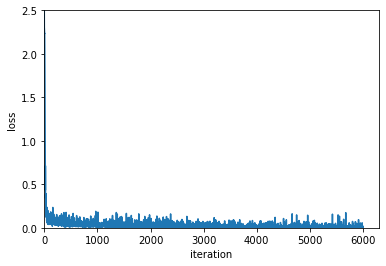

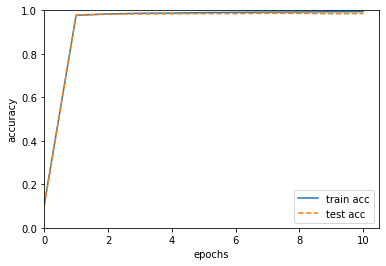

In [64]:
# 実装しました。
# coding: utf-8
import os
import sys
import matplotlib.pylab as plt
import numpy as np
sys.path.append(os.pardir)  # パスに親ディレクトリ追加
from dataset.mnist import load_mnist


# MNISTの訓練データとテストデータ読み込み
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, flatten=False, one_hot_label=True)

# ハイパーパラメーター設定
iters_num = 6000        # 更新回数
batch_size = 100        # バッチサイズ
learning_rate = 0.06    # 学習率、AdaGradを想定

train_size = x_train.shape[0]  # 訓練データのサイズ
iter_per_epoch = max(int(train_size / batch_size), 1)    # 1エポック当たりの繰り返し数

# シンプルな畳み込みニューラルネットワーク生成
network = SimpleConvNet(
    input_dim=(1, 28, 28),
    conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
    hidden_size=100, output_size=10, weight_init_std=0.01
)

# オプティマイザー生成
optimizer = AdaGrad(learning_rate)   # AdaGrad

# 学習前の認識精度の確認
train_acc = network.accuracy(x_train, t_train)
test_acc = network.accuracy(x_test, t_test)
train_loss_list = []            # 損失関数の値の推移の格納先
train_acc_list = [train_acc]    # 訓練データに対する認識精度の推移の格納先
test_acc_list = [test_acc]      # テストデータに対する認識精度の推移の格納先
print(f'学習前 [訓練データの認識精度]{train_acc:.4f} [テストデータの認識精度]{test_acc:.4f}')

# 学習開始
for i in range(iters_num):

    # ミニバッチ生成
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    grads = network.gradient(x_batch, t_batch)

    # 重みパラメーター更新
    optimizer.update(network.params, grads)

    # 損失関数の値算出
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1エポックごとに認識精度算出
    if (i + 1) % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        # 経過表示
        print(
            f'[エポック]{(i + 1) // iter_per_epoch:>2} '
            f'[更新数]{i + 1:>5} [損失関数の値]{loss:.4f} '
            f'[訓練データの認識精度]{train_acc:.4f} [テストデータの認識精度]{test_acc:.4f}'
        )

# 損失関数の値の推移を描画
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.xlim(left=0)
plt.ylim(0, 2.5)
plt.show()

# 訓練データとテストデータの認識精度の推移を描画
x2 = np.arange(len(train_acc_list))
plt.plot(x2, train_acc_list, label='train acc')
plt.plot(x2, test_acc_list, label='test acc', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xlim(left=0)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()